In [1]:
import inspect
import numpy
from matplotlib import offsetbox
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [2]:
class PredictableTSNE(BaseEstimator, TransformerMixin):

    def __init__(self, transformer=None, estimator=None,
                 normalize=True, keep_tsne_outputs=False, **kwargs):
        """
        :param transformer: `TSNE` by default
        :param estimator: `MLPRegressor` by default
        :param normalize: normalizes the outputs, centers and normalizes
            the output of the *t-SNE* and applies that same
            normalization to he prediction of the estimator
        :param keep_tsne_output: if True, keep raw outputs of
            *TSNE* is stored in member *tsne_outputs_*
        :param kwargs: sent to :meth:`set_params <mlinsights.mlmodel.
            tsne_transformer.PredictableTSNE.set_params>`, see its
            documentation to understand how to specify parameters
        """
        TransformerMixin.__init__(self)
        BaseEstimator.__init__(self)
        if estimator is None:
            estimator = KNeighborsRegressor()
        if transformer is None:
            transformer = TSNE()
        self.estimator = estimator
        self.transformer = transformer
        self.keep_tsne_outputs = keep_tsne_outputs
        if not hasattr(transformer, "fit_transform"):
            raise AttributeError(
                "Transformer {} does not have a 'fit_transform' "
                "method.".format(type(transformer)))
        if not hasattr(estimator, "predict"):
            raise AttributeError(
                "Estimator {} does not have a 'predict' method.".format(
                    type(estimator)))
        self.normalize = normalize
        if kwargs:
            self.set_params(**kwargs)

    def fit(self, X, y, sample_weight=None):
        """
        Runs a *k-means* on each class
        then trains a classifier on the
        extended set of features.
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            Training data
        y : numpy array of shape [n_samples, n_targets]
            Target values. Will be cast to X's dtype if necessary
        sample_weight : numpy array of shape [n_samples]
            Individual weights for each sample
        Returns
        -------
        self : returns an instance of self.
        Attributes
        ----------
        transformer_: trained transformeer
        estimator_: trained regressor
        tsne_outputs_: t-SNE outputs if *keep_tsne_outputs* is True
        mean_: average of the *t-SNE* output on each dimension
        inv_std_: inverse of the standard deviation of the *t-SNE*
            output on each dimension
        loss_: loss (*mean_squared_error*)
        between the predictions and the outputs of t-SNE
        """
        params = dict(y=y, sample_weight=sample_weight)

        self.transformer_ = clone(self.transformer)

        sig = inspect.signature(self.transformer.fit_transform)
        pars = {}
        for p in ['sample_weight', 'y']:
            if p in sig.parameters and p in params:
                pars[p] = params[p]
        target = self.transformer_.fit_transform(X, **pars)

        sig = inspect.signature(self.estimator.fit)
        if 'sample_weight' in sig.parameters:
            self.estimator_ = clone(self.estimator).fit(
                X, target, sample_weight=sample_weight)
        else:
            self.estimator_ = clone(self.estimator).fit(X, target)
        mean = target.mean(axis=0)
        var = target.std(axis=0)
        self.mean_ = mean
        self.inv_std_ = 1. / var
        exp = (target - mean) * self.inv_std_
        got = (self.estimator_.predict(X) - mean) * self.inv_std_
        self.loss_ = mean_squared_error(exp, got)
        if self.keep_tsne_outputs:
            self.tsne_outputs_ = exp if self.normalize else target
        return self

    def transform(self, X):
        """
        Runs the predictions.
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_features]
            Training data
        Returns
        -------
        tranformed *X*
        """
        pred = self.estimator_.predict(X)
        if self.normalize:
            pred -= self.mean_
            pred *= self.inv_std_
        return pred

    def get_params(self, deep=True):
        """
        Returns the parameters for all the embedded objects.
        """
        res = {}
        for k, v in self.transformer.get_params().items():
            res["t_" + k] = v
        for k, v in self.estimator.get_params().items():
            res["e_" + k] = v
        return res

    def set_params(self, **values):
        """
        Sets the parameters before training.
        Every parameter prefixed by ``'e_'`` is an estimator
        parameter, every parameter prefixed by
        ``t_`` is for a transformer parameter.
        """
        pt, pe, pn = {}, {}, {}
        for k, v in values.items():
            if k.startswith('e_'):
                pe[k[2:]] = v
            elif k.startswith('t_'):
                pt[k[2:]] = v
            elif k.startswith('n_'):
                pn[k[2:]] = v
            else:
                raise ValueError("Unexpected parameter name '{0}'.".format(k))
        self.transformer.set_params(**pt)
        self.estimator.set_params(**pe)

In [3]:
def plot_embedding(Xp, y, imgs, title=None, figsize=(12, 4)):
    x_min, x_max = numpy.min(Xp, 0), numpy.max(Xp, 0)
    X = (Xp - x_min) / (x_max - x_min)

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i in range(X.shape[0]):
        ax[0].text(X[i, 0], X[i, 1], str(y[i]),
                   color=plt.cm.Set1(y[i] / 10.),
                   fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = numpy.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = numpy.sum((X[i] - shown_images) ** 2, 1)
            if numpy.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = numpy.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(imgs[i], cmap=plt.cm.gray_r),
                X[i])
            ax[0].add_artist(imagebox)
    ax[0].set_xticks([]), ax[0].set_yticks([])
    ax[1].plot(Xp[:, 0], Xp[:, 1], '.')
    if title is not None:
        ax[0].set_title(title)
    return ax


C:\Program Files\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


array([<AxesSubplot:title={'center':'t-SNE embedding of the digits'}>,
       <AxesSubplot:>], dtype=object)

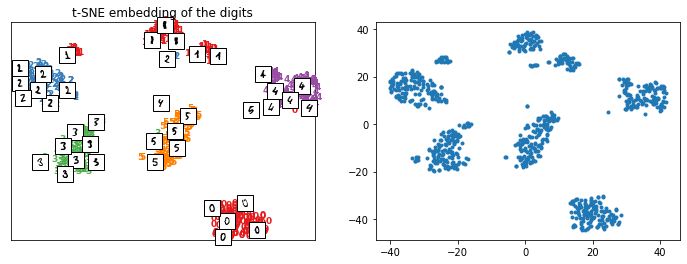

In [5]:
digits = datasets.load_digits(n_class=6)
Xd = digits.data
yd = digits.target
imgs = digits.images
n_samples, n_features = Xd.shape
n_samples, n_features

X_train, X_test, y_train, y_test, imgs_train, imgs_test = train_test_split(
    Xd, yd, imgs)

tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate=200.0)


X_train_tsne = tsne.fit_transform(X_train)
plot_embedding(X_train_tsne, y_train, imgs_train,
               "t-SNE embedding of the digits")

In [ ]:
ptsne_knn = PredictableTSNE()
ptsne_knn.fit(X_train, y_train)

X_train_tsne2 = ptsne_knn.transform(X_train)
plot_embedding(X_train_tsne2, y_train, imgs_train,
               "Predictable t-SNE of the digits\n"
               "StandardScaler+KNeighborsRegressor")

In [ ]:
X_test_tsne2 = ptsne_knn.transform(X_test)
plot_embedding(X_test_tsne2, y_test, imgs_test,
               "Predictable t-SNE of the digits\n"
               "StandardScaler+KNeighborsRegressor")